In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

cake = pd.read_csv('xnas-itch-20240822.mbo.CAKE.csv',parse_dates=['ts_recv', 'ts_event'])

In [2]:
cake.columns

Index(['ts_recv', 'ts_event', 'rtype', 'publisher_id', 'instrument_id',
       'action', 'side', 'price', 'size', 'channel_id', 'order_id', 'flags',
       'ts_in_delta', 'sequence', 'symbol'],
      dtype='object')

In [3]:
cake['action'].unique()

array(['R', 'A', 'C', 'T', 'F'], dtype=object)

In [4]:
cake_trades=pd.read_csv('xnas-itch-20240822.tbbo.CAKE.csv',parse_dates=['ts_recv', 'ts_event'])

In [5]:
cake_trades.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,symbol
0,2024-08-22 13:28:00.059387613+00:00,2024-08-22 13:28:00.059217193+00:00,1,2,2639,T,N,0,38.76,60,0,170420,14286651,38.00,40.53,1,1000,1,1,CAKE
1,2024-08-22 13:28:00.059387613+00:00,2024-08-22 13:28:00.059217547+00:00,1,2,2639,T,N,0,38.76,40,128,170066,14286652,38.00,40.53,1,1000,1,1,CAKE
2,2024-08-22 13:30:00.918500023+00:00,2024-08-22 13:30:00.918318809+00:00,1,2,2639,T,N,0,38.66,3061,0,181214,17284072,38.64,39.36,95,200,1,1,CAKE
3,2024-08-22 13:30:05.131885094+00:00,2024-08-22 13:30:05.131717397+00:00,1,2,2639,T,N,0,38.78,34,130,167697,17937927,38.60,38.97,234,100,5,1,CAKE
4,2024-08-22 13:30:45.269318156+00:00,2024-08-22 13:30:45.269151493+00:00,1,2,2639,T,A,0,38.75,1,130,166663,21393675,38.75,38.97,1,100,1,1,CAKE


In [6]:
cake_trades.columns

Index(['ts_recv', 'ts_event', 'rtype', 'publisher_id', 'instrument_id',
       'action', 'side', 'depth', 'price', 'size', 'flags', 'ts_in_delta',
       'sequence', 'bid_px_00', 'ask_px_00', 'bid_sz_00', 'ask_sz_00',
       'bid_ct_00', 'ask_ct_00', 'symbol'],
      dtype='object')

In [7]:
cake_trades['dollar_vol']=cake_trades['price']*cake_trades['size']

In [8]:
dtv=cake_trades.groupby(cake_trades['ts_event'].dt.floor('min'))['dollar_vol'].sum()

<Axes: title={'center': 'Dollar trading volume'}, xlabel='ts_event'>

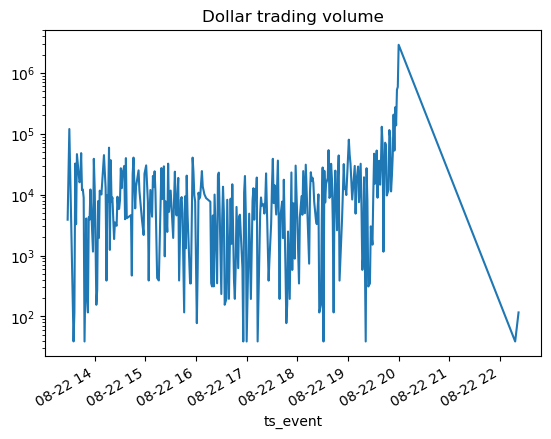

In [9]:
dtv.plot(title='Dollar trading volume',logy=True)

In [10]:
dtv.describe()

count    2.970000e+02
mean     2.912566e+04
std      1.748573e+05
min      3.867000e+01
25%      2.444520e+03
50%      8.180130e+03
75%      1.969411e+04
max      2.895873e+06
Name: dollar_vol, dtype: float64

In [11]:
trade_counts_min=cake_trades.groupby(cake_trades['ts_event'].dt.floor('min'))['sequence'].count()

<Axes: title={'center': 'No. of trades per min'}, xlabel='ts_event'>

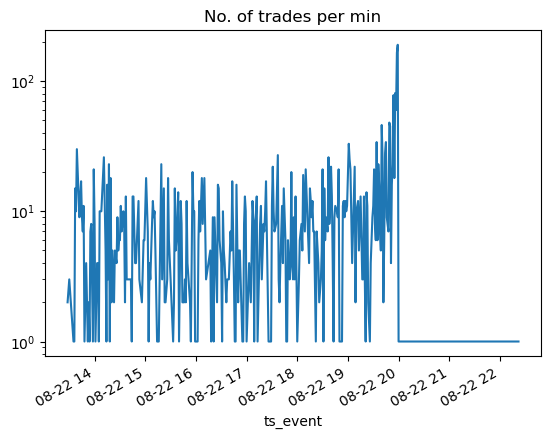

In [12]:
trade_counts_min.plot(title='No. of trades per min',logy=True)

In [13]:
trade_counts_min.describe()

count    297.000000
mean      10.218855
std       17.198638
min        1.000000
25%        3.000000
50%        7.000000
75%       12.000000
max      190.000000
Name: sequence, dtype: float64

In [14]:
order_counts_min=cake.groupby(cake['ts_event'].dt.floor('min'))['sequence'].count()

<Axes: xlabel='ts_event'>

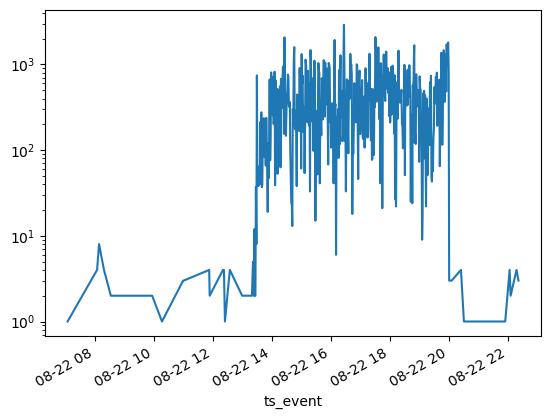

In [15]:
order_counts_min.plot(logy=True)

In [16]:
open=cake_trades.iloc[0]['price']
open

38.76

In [17]:
close=cake_trades.iloc[-1]['price']
close

38.74

In [18]:
high=max(cake_trades['price'])
high

39.09

In [19]:
low=min(cake_trades['price'])
low

38.265

In [20]:
cake_vwap=cake_trades.groupby(cake_trades['ts_event'].dt.floor('min')).apply(lambda x: (x['price'] * x['size']).sum() / x['size'].sum())

<Axes: xlabel='ts_event'>

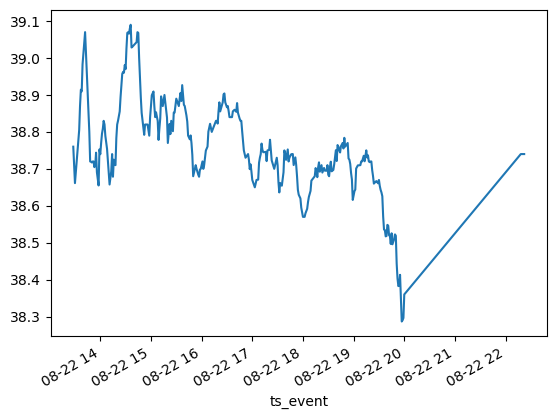

In [21]:
cake_vwap.plot()

In [22]:
cake_vwap.describe()

count    297.000000
mean      38.746883
std        0.136048
min       38.286692
25%       38.690647
50%       38.737566
75%       38.830000
max       39.090000
dtype: float64

In [23]:
cake_trades['spread']=cake_trades['ask_px_00']-cake_trades['bid_px_00']
cake_trades['avl']=0
for index,row in cake_trades.iterrows():
    if(row['side']=='A'):
        row['avl']=row['bid_sz_00']
    elif(row['side']=='B'):
        row['avl']=row['ask_sz_00']
    else:
        row['avl']=row['bid_sz_00']+row['ask_sz_00']

In [24]:
cake_spread_min=cake_trades.groupby(cake_trades['ts_event'].dt.floor('min'))['spread'].mean()

<Axes: xlabel='ts_event'>

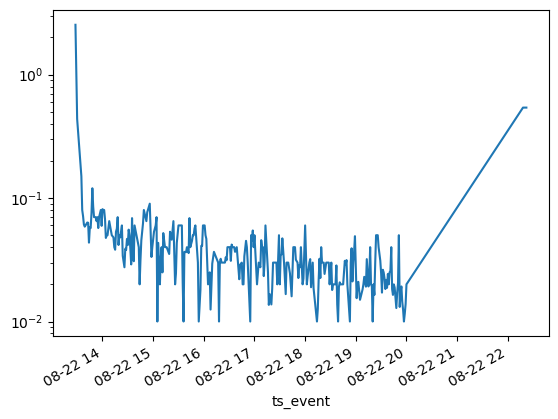

In [25]:
cake_spread_min.plot(logy=True)

In [26]:
cake_trades.loc[np.where(cake_trades['side']=='A')[0],'avl']=cake_trades.loc[np.where(cake_trades['side']=='A')[0],'bid_sz_00']
cake_trades.loc[np.where(cake_trades['side']=='B')[0],'avl']=cake_trades.loc[np.where(cake_trades['side']=='B')[0],'ask_sz_00']
cake_trades.loc[np.where(cake_trades['side']=='N')[0],'avl']=cake_trades.loc[np.where(cake_trades['side']=='N')[0],'bid_sz_00']+cake_trades.loc[np.where(cake_trades['side']=='N'),'ask_sz_00']

In [27]:
cake_depth_min=cake_trades.groupby(cake_trades['ts_event'].dt.floor('min'))['avl'].max()

<Axes: xlabel='ts_event'>

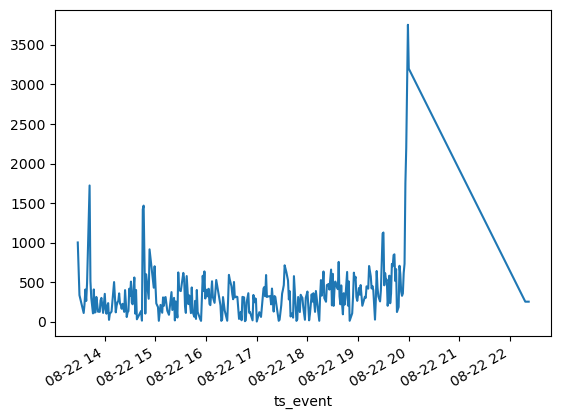

In [28]:
cake_depth_min.plot()

In [29]:
test_depth=2*cake_spread_min.mean()


In [34]:
cake_trades['mid']=(cake_trades['ask_px_00']+cake_trades['bid_px_00'])/2

In [35]:
cake_trades['test_ask']

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,symbol,dollar_vol,spread,avl,mid
0,2024-08-22 13:28:00.059387613+00:00,2024-08-22 13:28:00.059217193+00:00,1,2,2639,T,N,0,38.76,60,...,40.53,1,1000,1,1,CAKE,2325.60,2.53,1001,39.265
1,2024-08-22 13:28:00.059387613+00:00,2024-08-22 13:28:00.059217547+00:00,1,2,2639,T,N,0,38.76,40,...,40.53,1,1000,1,1,CAKE,1550.40,2.53,1001,39.265
2,2024-08-22 13:30:00.918500023+00:00,2024-08-22 13:30:00.918318809+00:00,1,2,2639,T,N,0,38.66,3061,...,39.36,95,200,1,1,CAKE,118338.26,0.72,295,39.000
3,2024-08-22 13:30:05.131885094+00:00,2024-08-22 13:30:05.131717397+00:00,1,2,2639,T,N,0,38.78,34,...,38.97,234,100,5,1,CAKE,1318.52,0.37,334,38.785
4,2024-08-22 13:30:45.269318156+00:00,2024-08-22 13:30:45.269151493+00:00,1,2,2639,T,A,0,38.75,1,...,38.97,1,100,1,1,CAKE,38.75,0.22,1,38.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3030,2024-08-22 19:59:59.265366088+00:00,2024-08-22 19:59:59.265195436+00:00,1,2,2639,T,A,0,38.34,80,...,38.36,1442,1809,10,3,CAKE,3067.20,0.02,1442,38.350
3031,2024-08-22 19:59:59.265366088+00:00,2024-08-22 19:59:59.265195436+00:00,1,2,2639,T,A,0,38.34,50,...,38.36,1362,1809,9,3,CAKE,1917.00,0.02,1362,38.350
3032,2024-08-22 20:00:00.233221913+00:00,2024-08-22 20:00:00.233042067+00:00,1,2,2639,T,N,0,38.36,75492,...,38.36,1505,1695,10,2,CAKE,2895873.12,0.02,3200,38.350
3033,2024-08-22 22:18:47.848309010+00:00,2024-08-22 22:18:47.848141552+00:00,1,2,2639,T,N,0,38.74,1,...,38.79,2,250,1,1,CAKE,38.74,0.54,252,38.520
